## Setup

In [1]:
%run -i path.py
# %run -i setup.py

Loaded PATH.



In [2]:
# System
import copy
import csv
import sys
import os
import watermark
import pickle
import itertools
import random
import zipfile
from collections import defaultdict
import pprint
pp = pprint.PrettyPrinter(indent=4)
from tqdm.notebook import tqdm
import warnings
from IPython.core.display import clear_output
import time
from datetime import date

# Math/Data
import math
import numpy as np
import pandas as pd
import requests
import json

# Network
import igraph as ig
import networkx as nx

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.collections import PatchCollection
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

In [3]:

# Geo
import osmnx as ox
#ox.utils.config(timeout = 300, logs_folder = PATH["logs"], log_file = True)
import fiona
import shapely
# from osgeo import gdal
# from osgeo import osr
# from haversine import haversine, haversine_vector
import pyproj
from shapely.geometry import Point, MultiPoint, LineString, Polygon, MultiLineString, MultiPolygon
import shapely.ops as ops
import geopandas as gpd
import geojson
#import geopy



# dict of placeid:placeinfo
# If a city has a proper shapefile through nominatim
# In case no (False), manual download of shapefile is necessary, see below
cities = {}
with open(PATH["parameters"] + 'cities.csv') as f:
    csvreader = csv.DictReader(f, delimiter=';')
    for row in csvreader:
        cities[row['placeid']] = {}
        for field in csvreader.fieldnames[1:]:
            cities[row['placeid']][field] = row[field]     

# Create city subfolders  
for placeid, placeinfo in cities.items():
    for subfolder in ["data", "plots", "results", "data_api"]:
        placepath = PATH[subfolder] + placeid + "/"
        if not os.path.exists(placepath):
            os.makedirs(placepath)
            print("Successfully created folder " + placepath)

from IPython.display import Audio
sound_file = '../dingding.mp3'

print("Setup finished.\n")


Setup finished.



## Functions

In [4]:
%run -i functions.py

Loaded functions.



# Create location for Bird API requests

In [5]:
# Download Turin networks
# Do not run this cell if you already downloaded the networks
G = ox.graph_from_place('Turin, Piemonte, Italy', network_type='all')

In [6]:
# Save to disk
# Do not run this cell if you already downloaded the networks
ox.save_graph_shapefile(G,PATH['data']+'graph_shapefile/Turin/')

d:\ProgramFiles\anaconda3\lib\site-packages\osmnx\io.py:87: UserWarning: The `save_graph_shapefile` function is deprecated and will be removed in a future release. Instead, use the `save_graph_geopackage` function to save graphs as GeoPackage files for subsequent GIS analysis.
  warnings.warn(
d:\ProgramFiles\anaconda3\lib\site-packages\osmnx\io.py:115: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_nodes.to_file(filepath_nodes, driver="ESRI Shapefile", index=True, encoding=encoding)


In [7]:
# gdf of the edges of Turin street network
gdf_edges = gpd.read_file(PATH['data']+'graph_shapefile/Turin/edges.shp')

<AxesSubplot:>

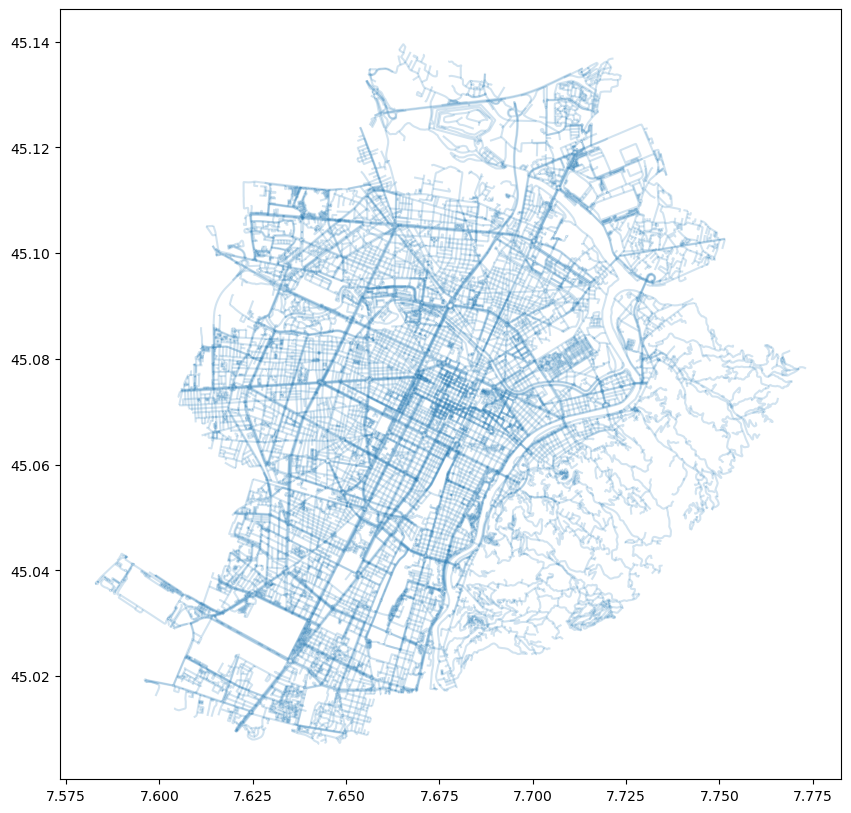

In [8]:
gdf_edges.plot(figsize=(20,10),alpha=0.2)

## Create a grid for the city center

In [9]:
# total area of the grid
ymax=45.10
ymin=45.03
xmin=7.62
xmax=7.72


# how many cells across and down
n_cells = 10

cell = create_grid(xmin,xmax,ymin,ymax,n_cells)

In [10]:
# this list contains the indices of peripheral boxes that we will remove
suburbs = [0,1,2,6,7,56,57,64,65,66,72,73,74,80,81,82,87]

# we will use the centroids of the boxes as coordinates for the query
# in the next cells we remove the peripheral points

points = cell.copy()

points['geometry'] = points['geometry'].centroid

points=points.drop(suburbs,axis=0)

In [11]:
print("Number of queries: ",len(points))
print("Side of the boxes: ",np.round(distance_meters(points['geometry'].loc[3], points['geometry'].loc[4])[1]),' m')

Number of queries:  71
Side of the boxes:  1506.0  m


d:\ProgramFiles\anaconda3\lib\site-packages\geopandas\array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as Kandawala / Sri Lanka Grid (the single non-null crs provided).
  warnings.warn(


<AxesSubplot:>

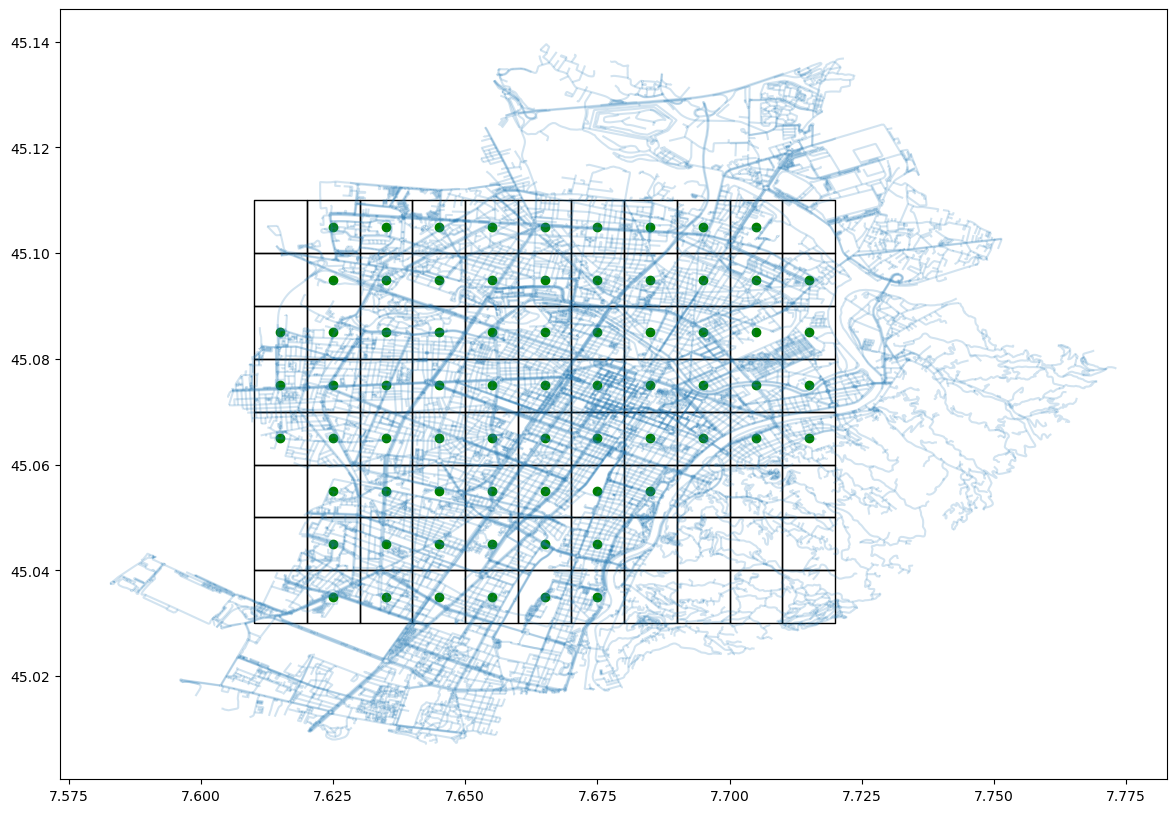

In [12]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(20,10),sharex=True, sharey=True)

ax = cell.plot(ax=ax,facecolor='none',edgecolor='black')
ax = gdf_edges.plot(ax = ax,alpha=0.2)
points.plot(ax=ax,figsize=(20,10), color='green')

## Create the .csv file with the boxe's centroids for the requests

In [13]:
# centroids

lat = points['geometry'].y
long = points['geometry'].x

lat_list = []
long_list = []
for i in range(len(lat)):
    lat_list.append(lat.iloc[i])
    long_list.append(long.iloc[i])
    
a = pd.DataFrame({'latitude':lat_list})
b = pd.DataFrame({'longitude':long_list})

c = pd.concat([a,b],axis=1)

# save the coordinates of these centroids
# we will use them to make the requests
c.to_csv(PATH['data']+ placeid + "/"+'request_location_centroids_turin.csv')

# Collect Bird data

This notebook is based on the instructions available here:
https://github.com/ubahnverleih/WoBike/blob/master/Bird.md

In [14]:
# get auth Token
# After running this cell, check your email to get the token

body = {"email": "jiangjin9909@gmail.com"}

headers = {
    'User-Agent': 'Bird/4.119.0(co.bird.Ride; build:3; iOS 14.3.0) Alamofire/5.2.2',
    'Device-Id': 'BC5BDA72-12A2-5DF4-BD11-92ACF8FFC86D', # is a random 16-bit GUID
    'Platform': 'ios',
    'App-Version': '4.119.0',
    'Content-Type': 'application/json'
    }

POST = 'https://api-auth.prod.birdapp.com/api/v1/auth/email'

r = requests.post(url=POST, headers=headers,json=body)

r.status_code

200

In [18]:
# get 'access' and 'refresh' codes

headers = {
    'User-Agent': 'Bird/4.119.0(co.bird.Ride; build:3; iOS 14.3.0) Alamofire/5.2.2',
    'Device-Id': 'BC5BDA72-12A2-5DF4-BD11-92ACF8FFC86D', # is a random 16-bit GUID
    'Platform': 'ios',
    'App-Version': '4.119.0',
    'Content-Type': 'application/json'
    }

tkn = {"token": "D51VcqQgR9AWVgXRAx6nTWA"} # replace "YOUR_TOKEN" with the token you received in the email

POST = "https://api-auth.prod.birdapp.com/api/v1/auth/magic-link/use"

r = requests.post(url=POST, headers=headers,json=tkn)

r.status_code

200

In [19]:
## access and refresh token
j = r.json()

## Refresh Auth Token

By default bird tokens expire after one day. They can be easily refreshed without having to get another magic link.

In [20]:
jj=refresh_token(j).json()

token refreshed, status code:  200


## Load the list of coordinates for the requests

In [21]:
coords = pd.read_csv(PATH['data']+ placeid + "/"+'request_location_centroids_turin.csv')
coords = coords.drop(['Unnamed: 0'],axis=1)

In [22]:
# create a list of dict: each dict contains the coordinates for a request

coords_list = []

for i in range(len(coords)):
    
    coord_dict = {'latitude': coords.iloc[i]['latitude'], 'longitude': coords.iloc[i]['longitude']}
    
    coords_list.append(coord_dict)

## Collect e-scooter position data

I used the tutorial:
https://www.dataquest.io/blog/python-api-tutorial/

In [23]:
responses = []

start_time = time.time()

# set the radius for the requests
R = 500 # (seems to be a dummy variable)

# set the duration (in seconds) of data collecting
duration = 13428000

end_time = start_time + duration

start_day = '2021-05-26'
end_day = '2021-10-28'

request_counter = 0 # if you re-start this cell, update this number to avoid overwriting the data

print('Data collection started at: ', time.ctime(start_time))

print('Data collection will end at: ', time.ctime(end_time))

# make the requests
while time.time() < end_time:
    dfs = []
    
    for i in range(len(coords_list)):
        # make the API call
        response = make_a_request(coords_list[i]['latitude'],coords_list[i]['longitude'],R,jj)
        
        # if we get an error, print the response and halt the loop
        if response.status_code != 200:
            print(response.text)
            jj = refresh_token(jj).json()
            response = make_a_request(coords_list[i]['latitude'],coords_list[i]['longitude'],R,jj)
            
        while response.status_code != 200:
            
            print('Status code = ', response.status_code)
            
            print("Wait 20 minutes than try again...")
            for i in range(20):
                time.sleep(60)
                print(20 - i - 1, " minutes to next try.")
                clear_output(wait=True)
            
            response = make_a_request(coords_list[i]['latitude'],coords_list[i]['longitude'],R,jj)
        
        # create a df with the data of the request
        r_json = response.json()
        r_json_bike = r_json['birds']
        r_df = pd.DataFrame(r_json_bike)
        
        # add to the df WHEN was made the request
        t = time.time()        
        r_df['Time'] = t
        
        # add to the df WHERE was made the request
        r_df['Request Latitude'] = coords_list[i]['latitude']
        r_df['Request Longitude'] = coords_list[i]['longitude']
        
        # rearrange the latitude and longitude data
        lats = []
        lons = []

        for k in range(len(r_df)):
            temp_df = pd.DataFrame(r_json['birds'][k])
            lats.append(temp_df.iloc[0]['location'])
            lons.append(temp_df.iloc[1]['location'])
    
        r_df['latitude'] = lats
        r_df['longitude'] = lons
        
        # delete the 'location' column
        r_df=r_df.drop(['location'], axis=1)
        
        #sort the columns of the df
        r_df=r_df[['id','latitude','longitude','code','model','vehicle_class','captive','partner_id','battery_level','estimated_range','area_key','nest_id','bounty_id','Time','Request Latitude','Request Longitude']]
        
        # append df to a list
        dfs.append(r_df)
        
        # print some output so we can see the status
        text_file = open("Updates.txt", "w")
        n = text_file.write('# '+str(i)+' - Time of the last request: ' + str(time.ctime(time.time())) + '-- Request counter: ' + str(request_counter))
        text_file.close()
        
        # append response to a list
        responses.append(response)
        
        # wait 25 seconds to make the following request, so you don't get banned
        time.sleep(25)
    
    # create a single df for each group of requests
    if len(dfs) == len(coords_list):
        df = pd.concat(dfs)
    
        # export the df as a .csv file
        df.to_csv(PATH['data_api']+ placeid + "/"+'TimeSlot'+str(request_counter)+'_Start'+str(start_day)+'_End'+str(end_day)+'.csv')
    
        request_counter = request_counter + 1
    
    else:
        # print an output to inform you that there is some problem
        text_file = open("Updates.txt", "w")
        n = text_file.write('# '+str(i)+' - Time of the last request: ' + str(time.ctime(time.time()))+ 'IS NOT WORKING - current TimeSlot: '+str(request_counter))
        text_file.close()
    
    #between each group of requests, sleep 20 min 
    time.sleep(1200)

Data collection started at:  Thu Jun 15 02:12:28 2023
Data collection will end at:  Fri Nov 17 11:12:28 2023


KeyError: "['nest_id'] not in index"

# Crash data

Run this notebook to get the data on crashes involving at least 1 bike or 1 e-scooter, including geolocation.

In [ ]:
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
from shapely.geometry import Point
import matplotlib.pyplot as plt
import shapely
import time
import random
from IPython.core.display import clear_output
import geopy

In [ ]:
# load paths

%run -i path.py

placeid = 'turin'

In [ ]:
# gdf of the edges of Turin street network
gdf_edges = gpd.read_file(PATH['data']+'graph_shapefile/Turin/edges.shp')

## Crashes in Turin (2020)

Download the csv file with all 2020 crashes in Turin available here:

http://aperto.comune.torino.it/dataset/elenco-incidenti-2020/resource/2975b2cd-cd02-4d24-9a3d-e44d0e68f891

In [ ]:
accidents2020 = pd.read_csv(PATH['data'] + 'Elenco_Incidenti_2020.csv', sep = ",",header=2)

In [ ]:
# get only crashes involving at least 1 bike ('velocipede') 
bike_crashes = accidents2020[accidents2020["Velocipede"] >= 1]

# get only crashes involving at least 1 e-scooter ('Micromobilita' elettrica') 
escoo_crashes = accidents2020[accidents2020["Micromobilita' elettrica"] >= 1]

# concat bike and e-scooter crashes
softmobility2020 = pd.concat([bike_crashes,escoo_crashes])

# sort the crashes by date
softmobility2020.sort_values('N. Ord',inplace=True)
softmobility2020 = softmobility2020.reset_index(drop=True)

In [ ]:
# convert lon and lat from str to float and replace ',' with '.'

commas = []
for i in range(len(softmobility2020)):
    if type(softmobility2020.iloc[i]['Latitudine']) == type(softmobility2020.iloc[0]['Latitudine']):
        if softmobility2020.iloc[i]['Latitudine'].find(',') != -1:
            commas.append(i)

for c in commas:
    softmobility2020.at[c,'Latitudine'] = float(softmobility2020.iloc[c]['Latitudine'].replace(',','.'))
    softmobility2020.at[c,'Longitudine'] = float(softmobility2020.iloc[c]['Longitudine'].replace(',','.'))   

In [ ]:
# identify the index of missing locations

missing_loc = []
for i in range(len(softmobility2020)):
    if i not in commas:
        missing_loc.append(i)

In [ ]:
# get the missing locations manually, using the annotations of column "Denominazione strada o centro abitato"

softmobility2020.at[ 15   ,'Latitudine']=45.0607070007085
softmobility2020.at[ 15   ,'Longitudine']=7.684978111262758
softmobility2020.at[ 78   ,'Latitudine']=45.08275811314921
softmobility2020.at[ 78   ,'Longitudine']=7.659489755440858
softmobility2020.at[ 89   ,'Latitudine']=45.06567607842894
softmobility2020.at[ 89   ,'Longitudine']=7.693580440098414
softmobility2020.at[ 297   ,'Latitudine']=45.10521775158704
softmobility2020.at[ 297   ,'Longitudine']=7.683001997770805
softmobility2020.at[ 299   ,'Latitudine']=45.116153386878366
softmobility2020.at[ 299   ,'Longitudine']=7.657704268935772
softmobility2020.at[ 301   ,'Latitudine']=45.07685864720485
softmobility2020.at[ 301   ,'Longitudine']=7.683674927897282
softmobility2020.at[ 310   ,'Latitudine']=45.09581172153073
softmobility2020.at[ 310   ,'Longitudine']=7.672257397770439
softmobility2020.at[ 322   ,'Latitudine']=45.07612878448956
softmobility2020.at[ 322   ,'Longitudine']=7.655983440098793
softmobility2020.at[ 324   ,'Latitudine']=45.08943975201474
softmobility2020.at[ 324   ,'Longitudine']=7.677871282428348
softmobility2020.at[ 340   ,'Latitudine']=45.06794811139389
softmobility2020.at[ 340   ,'Longitudine']=7.670548526604855
softmobility2020.at[ 348   ,'Latitudine']=45.08104830416534
softmobility2020.at[ 348   ,'Longitudine']=7.671097652057089
softmobility2020.at[ 358   ,'Latitudine']=45.06703948118164
softmobility2020.at[ 358   ,'Longitudine']=7.650882453592099
softmobility2020.at[ 367   ,'Latitudine']=45.08701943229711
softmobility2020.at[ 367   ,'Longitudine']=7.666188875513294

In [ ]:
# rename Latitudine->latitude and Longitudine->longitude
softmobility2020 = softmobility2020.rename({'Latitudine':'latitude', 'Longitudine':'longitude'}, axis=1)

In [ ]:
# export the manipulated dataset
softmobility2020.to_csv(PATH["data"] + placeid + "/" +'accidents_softmobility2020.csv')

In [ ]:
# add geometry to the crashes dataframe

geometry = [Point(xy) for xy in zip(softmobility2020.longitude, softmobility2020.latitude)]
gdf_crashes_softmobility20 = gpd.GeoDataFrame(softmobility2020, crs="EPSG:4326", geometry=geometry)

In [ ]:
# plot the crashes on Turin map

ax = gdf_edges.plot(figsize=(15,8),alpha=.1, color='navy')

gdf_crashes_softmobility20.plot(ax=ax,figsize=(24,16),color='darkgreen',alpha=.7)

## Crashes in Turin (2019)

Download the csv file with all 2019 crashes in Turin available here:

http://aperto.comune.torino.it/dataset/elenco-incidenti-nell-anno-2019-nella-citta-di-torino

In this dataset there is no "Micromobilita' elettrica" column, so there is no distinction between crashes involving bike and e-scooters. 2019 was the first year of usage of a new system to store the data, so a little more data processing is needed to set up our crash dataset.

## Adjust the dataset

In [ ]:
accidents2019 = pd.read_csv(PATH['data'] + 'Elenco_Incidenti_2019.csv', sep = ";",header=2)

In [ ]:
# get only crashes involving at least 1 bike ('velocipede') 
bike_crashes = accidents2019[accidents2019['Velocipede'] >= 1]

In [ ]:
bike_crashes = bike_crashes.reset_index(drop=True)
bike_crashes

In [ ]:
# convert lon and lat from str to float and replace ',' with '.'

commas = []
for i in range(len(bike_crashes)):
    if type(bike_crashes.iloc[i]['Latitudine']) == type(bike_crashes.iloc[0]['Latitudine']):
        if bike_crashes.iloc[i]['Latitudine'].find(',') != -1:
            commas.append(i)

for c in commas:
    bike_crashes.at[c,'Latitudine'] = float(bike_crashes.iloc[c]['Latitudine'].replace(',','.'))
    bike_crashes.at[c,'Longitudine'] = float(bike_crashes.iloc[c]['Longitudine'].replace(',','.'))   

In [ ]:
# get the coordinates from the address
# use geopy to get the coordinates of address with the sintax "via xxxxxx number"

to_check = []
indices_ok = []
double_address = []
lat = []
lon = []

for i in range(len(bike_crashes)):
    
    print(i+1,'/',len(bike_crashes))
    if i not in commas:
    
        # add the indices of NaN values to a list 
        if bike_crashes['Denominazione strada o centro abitato'].iloc[i] != bike_crashes['Denominazione strada o centro abitato'].iloc[i]:
            to_check.append(i)
    
        else:
            if bike_crashes['Denominazione strada o centro abitato'].iloc[i].find(',') == -1:
                locator = geopy.geocoders.Nominatim(user_agent='myGeocoder')
                location = locator.geocode(bike_crashes['Denominazione strada o centro abitato'].iloc[i]+', Turin, Italy')
                if location != None:
                    lat.append(location.latitude)
                    lon.append(location.longitude)
                    indices_ok.append(i)
        
                # if geopy does not understand the address, it will return a "NoneType" location
                # for these values add the indices to a list and then check using other methods
                else:
                    double_address.append(i)
            else:
                double_address.append(i)
            
    clear_output(wait=True)

# fix the values of lat lon found with the address
for j,i in enumerate(indices_ok):
    bike_crashes.at[i,'Latitudine']=lat[j]
    bike_crashes.at[i,'Longitudine']=lon[j]

In [ ]:
# these crashes are geolocated manually

bike_crashes.at[ 1 ,'Latitudine']=45.08397867996193
bike_crashes.at[ 1 ,'Longitudine']=7.6331809840222835
bike_crashes.at[ 2 ,'Latitudine']=45.062731480180126
bike_crashes.at[ 2 ,'Longitudine']=7.675381853324719
bike_crashes.at[ 3 ,'Latitudine']=45.0953810903701
bike_crashes.at[ 3 ,'Longitudine']=7.7016295686854805
bike_crashes.at[ 4 ,'Latitudine']=45.08666506427556
bike_crashes.at[ 4 ,'Longitudine']=7.6664945840237095
bike_crashes.at[ 5 ,'Latitudine']=45.0614095129451
bike_crashes.at[ 5 ,'Longitudine']=7.679731630039038
bike_crashes.at[ 6 ,'Latitudine']=45.10343434740111
bike_crashes.at[ 6 ,'Longitudine']=7.665395353347183
bike_crashes.at[ 7 ,'Latitudine']=45.07458629677788
bike_crashes.at[ 7 ,'Longitudine']=7.675906568674329
bike_crashes.at[ 11 ,'Latitudine']=45.082292367083184
bike_crashes.at[ 11 ,'Longitudine']=7.651418789895025
bike_crashes.at[ 12 ,'Latitudine']=45.108700735691194
bike_crashes.at[ 12 ,'Longitudine']=7.663120707321082
bike_crashes.at[ 15 ,'Latitudine']=45.03315612193116
bike_crashes.at[ 15 ,'Longitudine']=7.608621353308836
bike_crashes.at[ 16 ,'Latitudine']=45.0665234970732
bike_crashes.at[ 16 ,'Longitudine']=7.662149184012897
bike_crashes.at[ 17 ,'Latitudine']=45.089818940854144
bike_crashes.at[ 17 ,'Longitudine']=7.683439507310729
bike_crashes.at[ 23 ,'Latitudine']=45.03864839350646
bike_crashes.at[ 23 ,'Longitudine']=7.628703737968763
bike_crashes.at[ 24 ,'Latitudine']=45.06251120518977
bike_crashes.at[ 24 ,'Longitudine']=7.679944937981754
bike_crashes.at[ 25 ,'Latitudine']=45.07842477393402
bike_crashes.at[ 25 ,'Longitudine']=7.62333126867647
bike_crashes.at[ 27 ,'Latitudine']=45.065656676264496
bike_crashes.at[ 27 ,'Longitudine']=7.682180784012162
bike_crashes.at[ 28 ,'Latitudine']=45.0780465374868
bike_crashes.at[ 28 ,'Longitudine']=7.684441637990146
bike_crashes.at[ 30 ,'Latitudine']=45.077126730030734
bike_crashes.at[ 30 ,'Longitudine']=7.698149253332636
bike_crashes.at[ 31 ,'Latitudine']=45.06141312496538
bike_crashes.at[ 31 ,'Longitudine']=7.685231137981133
bike_crashes.at[ 48 ,'Latitudine']=45.0747549527113
bike_crashes.at[ 48 ,'Longitudine']=7.6853669686742565
bike_crashes.at[ 49 ,'Latitudine']=45.07792720152072
bike_crashes.at[ 49 ,'Longitudine']=7.646738414704918
bike_crashes.at[ 52 ,'Latitudine']=45.08222971421292
bike_crashes.at[ 52 ,'Longitudine']=7.6866550840211625
bike_crashes.at[ 53 ,'Latitudine']=45.09219891738017
bike_crashes.at[ 53 ,'Longitudine']=7.654388668683753
bike_crashes.at[ 54 ,'Latitudine']=45.05932559631996
bike_crashes.at[ 54 ,'Longitudine']=7.65572575332287
bike_crashes.at[ 55 ,'Latitudine']=45.08674286411487
bike_crashes.at[ 55 ,'Longitudine']=7.681648799366786
bike_crashes.at[ 56 ,'Latitudine']=45.076782958828
bike_crashes.at[ 56 ,'Longitudine']=7.656850607303557
bike_crashes.at[ 57 ,'Latitudine']=45.07845425178405
bike_crashes.at[ 57 ,'Longitudine']=7.6609859379903025
bike_crashes.at[ 107 ,'Latitudine']=45.06476705437338
bike_crashes.at[ 107 ,'Longitudine']=7.680401166734652
bike_crashes.at[ 277 ,'Latitudine']=45.08774215573367
bike_crashes.at[ 277 ,'Longitudine']=7.691090275540141
bike_crashes.at[ 281 ,'Latitudine']=45.08609848010586
bike_crashes.at[ 281 ,'Longitudine']=7.655025413625322

In [ ]:
# rename Latitudine->latitude and Longitudine->longitude
bike_crashes = bike_crashes.rename({'Latitudine':'latitude', 'Longitudine':'longitude'}, axis=1)

In [ ]:
# export the manipulated dataset
bike_crashes.to_csv(PATH["data"] + placeid + "/" +'accidents_softmobility2019.csv')

In [ ]:
# add geometry to the crashes dataframe

geometry = [Point(xy) for xy in zip(bike_crashes.longitude, bike_crashes.latitude)]
gdf_crashes_softmobility = gpd.GeoDataFrame(bike_crashes, crs="EPSG:4326", geometry=geometry)

In [ ]:
# plot the crashes on Turin map

ax = gdf_edges.plot(figsize=(15,8),alpha=.1, color='navy')

gdf_crashes_softmobility.plot(ax=ax,figsize=(24,16),color='darkgreen',alpha=.7)

# Generate OD data from e-scooter positions

In this notebook we process the e-scooter position data, collected using the notebook "1b_collect-escooter-data.ipynb" to generate Origin-Destination data that we can use to define a trips data set.

In [ ]:
# create a single dataframe with the collected data

start = 500
end = 555

start_day = '2021-05-26'
end_day = '2021-10-28'

frames = []

for i in range(start,end):
    
    print(i+1,'/',end)
    
    # load the data
    frame = pd.read_csv(PATH['data_api']+ placeid + "/"+'TimeSlot'+str(i)+'_Start'+str(start_day)+'_End'+str(end_day)+'.csv')

    # delete the overlapping data
    frame = frame.drop_duplicates(['id'],ignore_index=True)
    
    # append to a list of df
    frames.append(frame)
    
    clear_output(wait=True)

In [ ]:
# gdf of the edges of Turin street network
gdf_edges = gpd.read_file(PATH['data']+'graph_shapefile/Turin/edges.shp')

The function OD_data(frames,code,d_T,t_T) finds the positions of the vehicle identified by the variable "code" that are stored in the list of dataframes "frames". Then it identifies the movement made by the given vehicle. 2 threshold are defined to define the movements:
* "d_T" -> threshold (in meters) to define a movement: if the position of a vehicle changes of > d_T meters from frames[i-1] to frames[i], we consider it as a movement.
* "t_T" -> threshold (in minutes) to define a movement: we do not consider a change in the position as a movement if the time between the detection in frames[i-1] and frames[i] is > t_T minutes

It returns the coordinates of the Origin (O_lat and O_lon), the battery level of the Origin (O_battery), the coordinates of the Destination (D_lat and D_lon), the battery level of the Destination (D_battery), the codes that identifies the vehicle that made this movements (codes).

In [ ]:
# find OD_data for TimeSlot from i = start to i = end

d_T = 100 # threshold (in meters)
t_T = 90 # threshold (in minutes)

OD_list = []

# we take 100 frames (not all together), so we do not miss different vehicles with same unique code
for f in range(100,len(frames),100):
    
    # find unique values for 'code' in all df, then create a list with all the 'code' unique values found in data collection
    unique_code = find_unique_code(frames[f-100:f])

    # remove the data in which 'code' refears to more than 1 e-scooter
    code_list, doubles = remove_doubles(frames[f-100:f],unique_code)
    
    O_lat_tot = []
    O_lon_tot = []
    O_time_tot = []
    O_battery_tot = []
    D_lat_tot = []
    D_lon_tot = []
    D_time_tot = []
    D_battery_tot = []
    codes_tot = []

    for j,code in enumerate(code_list):
    
        print(j+1,'/',len(code_list))
    
        O_lat,O_lon,O_time,O_battery,D_lat,D_lon,D_time,D_battery,codes = OD_data(frames[f-100:f],code,d_T,t_T)
    
        O_lat_tot = O_lat_tot + O_lat
        O_lon_tot = O_lon_tot + O_lon
        O_time_tot = O_time_tot + O_time
        O_battery_tot = O_battery_tot + O_battery
        D_lat_tot = D_lat_tot + D_lat
        D_lon_tot = D_lon_tot + D_lon
        D_time_tot = D_time_tot + D_time
        D_battery_tot = D_battery_tot + D_battery
        codes_tot = codes_tot + codes
    
        clear_output(wait=True)
        
    data = {
    'O_lat' : O_lat_tot,
    'O_lon' : O_lon_tot,
    'D_lat' : D_lat_tot,
    'D_lon' : D_lon_tot,
    'O_time' : O_time_tot,
    'D_time' : D_time_tot,
    'O_battery' : O_battery_tot,
    'D_battery' : D_battery_tot,
    'code' : codes_tot
    }
    
    # set the od_data into a df
    OD_matrix0_100 = pd.DataFrame(data, columns = list(data.keys()))

    #sort dataframe by O_time
    OD_matrix0_100 = OD_matrix0_100.sort_values(by='O_time')
    OD_matrix0_100 = OD_matrix0_100.reset_index()
    OD_matrix0_100 = OD_matrix0_100.drop(['index'],axis=1)

    # add a column with O_battery - D_battery: we use this value to remove the movements made by the company (negative values)
    OD_matrix0_100['batt_diff'] = OD_matrix0_100['O_battery']-OD_matrix0_100['D_battery']
      
    # remove movements made by the company
    a = OD_matrix0_100[OD_matrix0_100['D_battery'] < 99] # remove data if the destination battery level is > 98 (it means it did not decrease after a trip)
    clean_OD = a[a['batt_diff']>0].reset_index() # remove data if battery_origin-battery_destination < 1 
    clean_OD = clean_OD.drop(['index'],axis=1)
    
    OD_list.append(clean_OD)

In [ ]:
final_OD = pd.concat(OD_list,axis=0)

# export the OD data
final_OD.to_csv(PATH['data']+ placeid + "/" + "OD_data.csv")

# Population density data
I found the shapefiles of the neighborhood of Turin here:

http://geoportale.comune.torino.it/geodati/zip/zonestat_popolazione_residente_geo.zip


I found the data on number of residents by neighborhood of 2020 here:

http://aperto.comune.torino.it/en/dataset/popolazione-per-sesso-e-zona-statistica-2020

In this notebook I combine in one file the geometry of the first file with the population data of the second one. From these data I also compute the density of population by neighborhood.

In [ ]:
# gdf of the edges of Turin street network
gdf_edges = gpd.read_file(PATH['data']+'graph_shapefile/Turin/edges.shp')

In [ ]:
# pop data (zone statistiche) 2020

# load the shapefile
pop_shp = gpd.read_file(PATH["data"]+'zonestat_popolazione_residente_2007_geo.shp')

# load the population data
pop_csv = pd.read_csv(PATH["data"]+'Torino_pop_zone-statistiche.csv')

In [ ]:
pop_shp.crs

In [ ]:
pop_shp = pop_shp.to_crs(4326)

In [ ]:
per_Area = gpd.read_file(PATH["data"]+'zonestat_popolazione_residente_2007_geo.shp')

per_Area.crs

In [ ]:
# we need to keep crs= EPSG:3003 to calculate the area of the polygons
per_Area = per_Area.sort_values(by='ZONA_STATI')

In [ ]:
pop_shp = pop_shp.sort_values(by='ZONA_STATI')
pop_shp

In [ ]:
# calculate population density 2020 and add it to 'pop_shp'

dens_f = []
dens_m = []
dens_t = []
for i in range(len(pop_csv)):
    dens_f.append(pop_csv['Femmine'].iloc[i]/(per_Area['geometry'].iloc[i].area/1e6))
    dens_m.append(pop_csv['Maschi'].iloc[i]/(per_Area['geometry'].iloc[i].area/1e6))
    dens_t.append((pop_csv['Maschi'].iloc[i]+pop_csv['Femmine'].iloc[i])/(per_Area['geometry'].iloc[i].area/1e6))

pop_shp['dens_fpop'] = dens_f
pop_shp['dens_mpop'] = dens_m
pop_shp['dens_totpop'] = dens_t

pop_shp

In [ ]:
# create a column in the pop_csv df with the number that identify the 'zona statistica'

n_zonastat = []

for ii in range(len(pop_csv)):
    zona = pop_csv['Zona_Statistica'].iloc[ii]
    for i in range(len(zona)):
        if zona[i] == ' ':
            n_zonastat.append(zona[:i])
            break

pop_csv['ZONASTAT'] = n_zonastat

In [ ]:
# remove the number of residents of 2007 (we keep the geometry from this file and the number of residents from pop_csv)
pop_shp = pop_shp.drop(['NMASCHI','NFEMMINE','TOTALE','ANNO'],axis=1)

In [ ]:
# add the number of resident of 2020 in pop_shp

pop = []
popF = []
popM = []


for i in range(len(pop_shp)):
    pop.append(pop_csv.iloc[i]['Femmine']+pop_csv.iloc[i]['Maschi'])
    popF.append(pop_csv.iloc[i]['Femmine'])
    popM.append(pop_csv.iloc[i]['Maschi'])
    
pop_shp['tot_pop'] = pop
pop_shp['female_pop'] = popF
pop_shp['male_pop'] = popM

In [ ]:
# plot the density on the map

fig, axes = plt.subplots(nrows=1,ncols=1, figsize=(25,25), sharex=True, sharey=True)

matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)

divider = make_axes_locatable(axes)

axes.set_title('Residents in Turin',fontsize=40)
        
cax = divider.append_axes('right', size='2%', pad=0.6)
cax.set_xlabel('Pop. density',labelpad=20,size='xx-large')
axes = pop_shp.plot(column='dens_totpop',cmap='OrRd', legend=True,ax=axes, cax=cax, alpha = .9)

gdf_edges.plot(ax = axes,alpha=.2, color='black')

In [ ]:
pop_shp.to_file(driver = 'ESRI Shapefile', filename = PATH["data"]+ placeid + "/"+'popTorino2020')

# Download networks

This notebook was developed by Michael Szell, you can find it here:

https://github.com/mszell/bikenwgrowth

Name: "01_prepare_networks.ipynb"

This notebook downloads bicycle and street network data sets and prepares them for analysis.

## Preliminaries

### Parameters

In [24]:
debug = True # If True, will produce plots and/or verbose output to double-check
%run -i "../parameters/parameters.py"

Loaded parameters.



## Download and wrangle data

### Networks

In [25]:
for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
        if debug: # Draw location polygons and their holes
            try:
                color = cm.rainbow(np.linspace(0,1,len(location)))
                for poly,c in zip(location, color):
                    plt.plot(*poly.exterior.xy, c = c)
                    for intr in poly.interiors:
                        plt.plot(*intr.xy, c = "red")
            except:
                plt.plot(*location.exterior.xy)
            plt.show()
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        location = shapely.geometry.shape(first['geometry'])
    
    Gs = {}
    for parameterid, parameterinfo in tqdm(osmnxparameters.items(), desc = "Networks", leave = False):
        for i in range(0,10): # retry
            try:
                Gs[parameterid] = ox.graph_from_polygon(location, 
                                       network_type = parameterinfo['network_type'],
                                       custom_filter = (parameterinfo['custom_filter']),
                                       retain_all = parameterinfo['retain_all'],
                                       simplify = False)
            except ValueError:
                Gs[parameterid] = nx.empty_graph(create_using = nx.MultiDiGraph)
                print(placeid + ": No OSM data for graph " + parameterid + ". Created empty graph.")
                break
            except ConnectionError or UnboundLocalError:
                print("ConnectionError or UnboundLocalError. Retrying.")
                continue
            except:
                print("Other error. Retrying.")
                continue
            break
        if parameterinfo['export']: ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)

    # Compose special cases biketrack, bikeable, biketrackcarall
    parameterid = 'biketrack'
    Gs[parameterid] = nx.compose_all([Gs['bike_cyclewaylefttrack'], Gs['bike_cyclewaytrack'], Gs['bike_highwaycycleway'], Gs['bike_bicycleroad'], Gs['bike_cyclewayrighttrack'], Gs['bike_designatedpath'], Gs['bike_cyclestreet']])
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    parameterid = 'bikeable'
    Gs[parameterid] = nx.compose_all([Gs['biketrack'], Gs['car30'], Gs['bike_livingstreet']]) 
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
    
    parameterid = 'biketrackcarall'
    Gs[parameterid] = nx.compose(Gs['biketrack'], Gs['carall']) # Order is important
    ox_to_csv(Gs[parameterid], PATH["data"] + placeid + "/", placeid, parameterid)
        
    for parameterid in networktypes[:-2]:
        #G_temp = nx.MultiDiGraph(ox.utils_graph.get_digraph(ox.simplify_graph(Gs[parameterid]))) # This doesnt work - cant get rid of multiedges
        ox_to_csv(ox.simplify_graph(Gs[parameterid]), PATH["data"] + placeid + "/", placeid, parameterid, "_simplified")

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

TypeError: 'MultiPolygon' object is not iterable

In [ ]:
# Compress all data files (will not do anything if files were compressed already)
for folder, subfolders, files in os.walk(PATH["data"]):
    for file in files:
        if file.endswith('es.csv'):
            compress_file(folder + "/", file.split(".")[0])

In [ ]:
Audio(sound_file, autoplay=True)

# Define seed points

This notebook is based on the notebook of Michael Szell "02_prepare_pois.ipynb" that you can find here:

https://github.com/mszell/bikenwgrowth

## Download and wrangle data

In [26]:
# Load all carall graphs in OSMNX format
parameterinfo = osmnxparameters['carall']

for placeid, placeinfo in tqdm(cities.items(), desc = "Cities"):
    print(placeid + ": Loading location polygon and carall graph")
    
    if placeinfo["nominatimstring"] != '':
        location = ox.geocoder.geocode_to_gdf(placeinfo["nominatimstring"])
        location = fill_holes(extract_relevant_polygon(placeid, shapely.geometry.shape(location['geometry'][0])))
    else:
        # https://gis.stackexchange.com/questions/113799/how-to-read-a-shapefile-in-python
        shp = fiona.open(PATH["data"] + placeid + "/" + placeid + ".shp")
        first = next(iter(shp))
        location = shapely.geometry.shape(first['geometry'])
    
    
G_biketrackcarall = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_biketrackcarall.graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
G_biketrackcarall_simplified = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall_simplified')
G_biketrackcarall_simplified.graph["crs"] = 'epsg:4326' # needed for OSMNX's graph_to_gdfs in utils_graph.py
    
# Load biketrack network (iGraph format)
G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')

Cities:   0%|          | 0/1 [00:00<?, ?it/s]

turin: Loading location polygon and carall graph


TypeError: 'MultiPolygon' object is not iterable

In [ ]:
# Load pop data (Turin 2020)
pop_shp = gpd.read_file(PATH["data"] + placeid + "/" +'popTorino2020')

# all the seed points located in regions with pop density < min_density will be removed

min_density = 1185

low_pop_density = pop_shp[pop_shp['dens_totpo'] < min_density]

# remove from the low_pop_density df the city-centre regions (parks)

low_pop_density = low_pop_density.drop([1,9,37])

Using code from: https://github.com/gboeing/osmnx-examples/blob/v0.11/notebooks/17-street-network-orientations.ipynb

In [ ]:
delta = 300 # delta param
  
# FIRST, determine the most common bearing, for the best grid orientation
G = G_biketrackcarall
bearings = {}    
# calculate edge bearings
Gu = ox.bearing.add_edge_bearings(ox.get_undirected(G))

# weight bearings by length (meters)
city_bearings = []
for u, v, k, d in Gu.edges(keys = True, data = True):
    city_bearings.extend([d['bearing']] * int(d['length']))
b = pd.Series(city_bearings)
bearings = pd.concat([b, b.map(reverse_bearing)]).reset_index(drop = 'True')

bins = np.arange(bearingbins + 1) * 360 / bearingbins
count = count_and_merge(bearingbins, bearings)
principalbearing = bins[np.where(count == max(count))][0]


# SECOND, construct the grid
G = G_biketrackcarall_simplified

# 1) Get lat lon window, with buffer for snapping outside seed points
# https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
buf = max(((2*snapthreshold) / 6378000) * (180 / math.pi), 
        ((2*snapthreshold) / 6378000) * (180 / math.pi) / math.cos(location.centroid.y * math.pi/180)
        )
cities[placeid]["bbox"] = location.buffer(buf).bounds

# 2) Generate abstract grid points in window
# https://stackoverflow.com/questions/40342355/how-can-i-generate-a-regular-geographic-grid-using-python
# Set up projections
p_ll = pyproj.Proj('+proj=longlat +datum=WGS84')
aeqd_proj = '+proj=aeqd +lat_0={lat} +lon_0={lon} +x_0=0 +y_0=0'
p_mt = pyproj.Proj(aeqd_proj.format(lat=location.centroid.y, lon=location.centroid.x)) # equidistant projection

# Make the area larger to account for tilted grid
deltax = cities[placeid]["bbox"][2] - cities[placeid]["bbox"][0]
deltay = cities[placeid]["bbox"][3] - cities[placeid]["bbox"][1]
enlargefactor = 10

# Create corners of rectangle to be transformed to a grid
sw = shapely.geometry.Point((cities[placeid]["bbox"][0], cities[placeid]["bbox"][1]))
ne = shapely.geometry.Point((cities[placeid]["bbox"][2]+enlargefactor*deltax, cities[placeid]["bbox"][3]+enlargefactor*deltay))
    
# Project corners to target projection
transformed_sw = pyproj.transform(p_ll, p_mt, sw.x, sw.y) # Transform NW point to equidistant
transformed_ne = pyproj.transform(p_ll, p_mt, ne.x, ne.y) # .. same for SE

# Iterate over 2D area
principalbearing = principalbearing % 90 # Take it modulo 90 because it will be a square grid
if principalbearing > 45:
    principalbearing -= 90 # Make bearing fall btw -45 and 45

xcoords = np.arange(transformed_sw[0], transformed_ne[0], gridl)
ycoords = np.arange(transformed_sw[1], transformed_ne[1], gridl)
xsize =  xcoords.size
ysize = ycoords.size
xcoords = np.tile(xcoords, ysize)
ycoords = np.repeat(ycoords, xsize)
gridpoints=[(x, y) for x, y in zip(xcoords, ycoords)]
new_points = rotate_grid(gridpoints, origin = transformed_sw, degrees = principalbearing)
    
# https://stackoverflow.com/questions/42459068/projecting-a-numpy-array-of-coordinates-using-pyproj
fx, fy = pyproj.transform(p_mt, p_ll, new_points[:,0], new_points[:,1])
gridpoints = np.dstack([fx, fy])[0]
if principalbearing >=0:
    # If we rotated right, we need to shift everything to the left
    gridpoints[:,0] -= 0.4*enlargefactor*deltax*math.sin(np.deg2rad(principalbearing))
else:
    # If we rotated left, we need to shift everything down and to the right
    gridpoints[:,0] += 0.4*enlargefactor*deltax*math.sin(np.deg2rad(principalbearing))
    gridpoints[:,1] -= 0.4*enlargefactor*deltay

# Cut back to bounding box
mask = (gridpoints[:,0] >= cities[placeid]["bbox"][0]) & (gridpoints[:,0] <= cities[placeid]["bbox"][2]) & (gridpoints[:,1] >= cities[placeid]["bbox"][1]) & (gridpoints[:,1] <= cities[placeid]["bbox"][3])
gridpoints_cut = gridpoints[mask]

# 3) Snap grid points to map

nnids = set() # set of nodes (seed points)
    
# add to the seed points the nodes of the existing bike net
existing_nnids = G_biketrack.vs['id']        
    
for n in existing_nnids:    
    add_point = True
        
        
    if G.has_node(n):
            
        # check that the POI is not in a low density region
        for kkk in range(len(low_pop_density)):
            if Point(G.nodes[n]["x"],G.nodes[n]["y"]).within(low_pop_density['geometry'].iloc[kkk]):
                add_point = False
                break
            
        # check that the seed points distance is <= delta for each pair of seed points; if not, remove the POI
        if add_point:
            for jj in nnids:
                if haversine((G.nodes[jj]["y"], G.nodes[jj]["x"]), (G.nodes[n]["y"], G.nodes[n]["x"]), unit="m") <= delta:
                    add_point = False
                    break
                    
    else:
        add_point = False
        
    # add the node to the seed points set if no exception occurred
    if add_point:
        nnids.add(n)
        
# add to the seed points the grid nodes
    
for g in gridpoints_cut:
    n = ox.distance.get_nearest_node(G, [g[1], g[0]])
    add_point = True
    if n not in nnids and haversine((g[1], g[0]), (G.nodes[n]["y"], G.nodes[n]["x"]), unit="m") <= snapthreshold:
            
        # check that the seed point is not in a low density region
        for kkk in range(len(low_pop_density)):
            if Point(G.nodes[n]["x"],G.nodes[n]["y"]).within(low_pop_density['geometry'].iloc[kkk]):
                add_point = False
                break
            
        # check that the new seed point is at least delta m far the other seed points
        if add_point:
            for jj in nnids:
                if haversine((G.nodes[jj]["y"], G.nodes[jj]["x"]), (G.nodes[n]["y"], G.nodes[n]["x"]), unit="m") <= delta:
                    add_point = False
                    break
                    
        # add the node to the seed points set if no exception occurred        
        if add_point:
            nnids.add(n)

# save the nodes for the seed points
with open(PATH["data"] + placeid + "/" + placeid + '_seed-points_delta' + str(delta) + '.csv', 'w') as f:
    for item in nnids:
        f.write("%s\n" % item)

# Define number of crashes and trips per link

In this notebook:

(1) The trips passing through each node of the biketrackcarall network are counted.

(2) The number of crashes and trips passing through each potential link is counted.

(3) The number of crashes and trips passing through the links of the existing infrastructure is counted.

## Import the data

In [ ]:
# Load networks

G_biketrackcarall_OX = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_biketrackcarall_ALL = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_biketrackcarall_simplified = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall_simplified')
G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
G_biketracksimplified = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack_simplified')

In [ ]:
#load OD data

OD = pd.read_csv(PATH["data"] + placeid + "/" + "OD_data.csv")
OD = OD.drop(['Unnamed: 0'], axis = 1)

#load 2019 crash data

accidents_softmobility = pd.read_csv(PATH["data"] + placeid + "/" +'accidents_softmobility2019.csv')


## (1) Create a df with the number of trips passing through each node of the biketrackcarall network

### Get shortest paths

In [ ]:
# choose "howmany" OD data randomly and get the shortest path on the network

howmany = 30000 # number of trips requested. Make sure you exclude at least M trips (e.g. 500 trips) to evaluate the trip coverage on unseen trips
s = 10 # random seed to order randomly the trips. Make sure you provided the same random seed to the function calculate_tripscovered()

ids = list(np.arange(len(OD)))

random.seed(s)
random.shuffle(ids)
selected_ids = ids[:howmany]

routenodepairs = list()

for j,i in enumerate(selected_ids):
    
    print(j+1,'/',len(selected_ids))
    nO=ox.distance.get_nearest_node(G_biketrackcarall_OX, [OD['O_lat'].iloc[i], OD['O_lon'].iloc[i]])
    nD=ox.distance.get_nearest_node(G_biketrackcarall_OX, [OD['D_lat'].iloc[i], OD['D_lon'].iloc[i]])
    routenodepairs.append((nO,nD))
    clear_output(wait=True)

### Snap the shortest paths on the road network
The following cell create a network based on the "biketrackcarall" network, selecting all the edges crossed at least once by a trip.

In [ ]:
tot_e = []
bike_e = []
GT_indices = set()
GT_indices_list = list()
for i,poipair in enumerate(routenodepairs):
    
    print(i+1,'/',len(routenodepairs))
    poipair_ind = (G_biketrackcarall_ALL.vs.find(id = poipair[0]).index, G_biketrackcarall_ALL.vs.find(id = poipair[1]).index)
    sp = set(G_biketrackcarall_ALL.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
    GT_indices = GT_indices.union(sp)
    for n in sp:
        GT_indices_list.append(n)
    clear_output(wait=True)
    
GT = G_biketrackcarall_ALL.induced_subgraph(GT_indices)    
    
tot_e.append(len(GT.es))

### snap the shortest paths on the road network and weight the network with the frequency of usage of links
The following cell create a network based on the "biketrackcarall" network, selecting all the edges crossed at least once by a trip. It also adds an edge weight labeled "n_trips" with the number of trips that cross the edge.

In [ ]:
tot_e = []
bike_e = []

used_links = {}

for i,poipair in enumerate(routenodepairs):
    GT_indices = set()
    print(i+1,'/',len(routenodepairs))
    poipair_ind = (G_biketrackcarall.vs.find(id = poipair[0]).index, G_biketrackcarall.vs.find(id = poipair[1]).index)
    sp = set(G_biketrackcarall.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "epath")[0])
    for n in sp:
        if str(n) not in list(used_links.keys()):
            used_links[str(n)] = 1
        else:
            used_links[str(n)] += 1
        
        G_biketrackcarall.es[n]['n_trips'] = used_links[str(n)]
            
    clear_output(wait=True)

for c,e in enumerate(G_biketrackcarall.es):
    if e['n_trips'] == None:
        e['n_trips'] = 0

In [ ]:
# calculate how many trips pass through each node

trips_nodes = {}

for vv in G_biketrackcarall.vs:
    trips_nodes[vv['id']] = {'x': vv['x'], 'y': -vv['y'], 'trips': 0}

for i,poipair in enumerate(routenodepairs):
    GT_indices = set()
    print(i+1,'/',len(routenodepairs))
    poipair_ind = (G_biketrackcarall.vs.find(id = poipair[0]).index, G_biketrackcarall.vs.find(id = poipair[1]).index)
    sp = set(G_biketrackcarall.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
    
    for n in sp:
        trips_nodes[G_biketrackcarall.vs[n]['id']]['trips'] += 1
    
    clear_output(wait=True)

In [ ]:
# save in csv file the trips per node

node_ids = []
lat = []
lon = []
trips = []

for i,t in enumerate(trips_nodes):
    print(i+1, '/',len(trips_nodes))
    node_ids.append(t)
    lat.append(trips_nodes[t]['y'])
    lon.append(trips_nodes[t]['x'])
    trips.append(trips_nodes[t]['trips'])
    clear_output(wait=True)
    

data = {'ids' : node_ids, 'lat' : lat, 'lon' : lon, 'trips' : trips}    
trips_per_node_df = pd.DataFrame(data)

trips_per_node_df.to_csv(PATH['data'] + placeid + "/" +'/trips_per_node-seed10.csv')

## (2) Count the number of crashes and trips passing through each potential link

In [ ]:
# Load seed points

delta = 300

with open(PATH["data"] + placeid + "/" + placeid + '_seed-points_delta' + str(delta) + '.csv') as f:
    nnids = [int(line.rstrip()) for line in f]
    
len(nnids)

In [ ]:
limited_abstract_edges = None # set limited_abstract_edges meters != None (e.g. 5000 meters) for big cities

#calculate distance between each pair of seed points
poipairs = poipairs_by_distance(G_biketrackcarall_ALL, nnids,True)


# limit the seed points pairs to abstract links with length < limited_abstract_edges meters
# we suggest to set limited_abstract_edges meters != None (e.g. 5000 meters) for big cities (e.g. when len(nnids)>700) for time computation reasons

if limited_abstract_edges != None:
    for ix,poipair in enumerate(poipairs):
        if poipair[1] > limited_abstract_edges:
            poipairs = copy.deepcopy(poipairs[:ix])
            limit_idx = ix
            break

print(len(poipairs))

### Calculate the number of crashes for each routed link

In [ ]:
start = time.time()
poipairs_list = list()
poipairs_dict = dict()

i = 1
middle_start = time.time()

# iterate over all poipairs (each poipair has a link in GT_abstract)
for poipair, poipair_distance in poipairs:
    
    print(i,'/',len(poipairs))
    print('Time last poipair: ', np.round((time.time()-middle_start),2), ' s')
    print('Tot time: ', np.round((time.time()-start)/60,2),' minutes')
    text_file = open("Accidents&Trips.txt", "w")
    n = text_file.write(str(i)+'/'+str(len(poipairs))+' - Time last poipair: '+str(np.round((time.time()-middle_start),2))+ ' s' + ' - Tot time: '+str(np.round((time.time()-start)/60,2)) + ' minutes')
    text_file.close()
    middle_start = time.time()
    
    acc_counter = 0
   
    
    GT_indices = set()
        
    poipair_ind = (G_biketrackcarall_ALL.vs.find(id = poipair[0]).index, G_biketrackcarall_ALL.vs.find(id = poipair[1]).index)
    sp = set(G_biketrackcarall_ALL.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
    GT_indices = GT_indices.union(sp)
    
    G_temp = G_biketrackcarall_ALL.induced_subgraph(GT_indices)
    
    
    # compute the cover area of the link (with a buffer = 50 m)
    covered_area,cov = calculate_coverage_edges(G_temp, buffer_m = 50, return_cov = True)
    
    # count how many accidents are located in the covered area
    for k in range(len(accidents_softmobility)):
        if Point(accidents_softmobility.iloc[k]['longitude'],-accidents_softmobility.iloc[k]['latitude']).within(cov):
            acc_counter += 1
    
    # add to a list poipairs, how many accidents the link covers
    poipairs_list.append([poipair,poipair_distance,acc_counter])
    
    # add to a dict poipairs (as key), how many accidents the link covers
    poipairs_dict[str(poipair[0])+','+str(poipair[1])] = acc_counter
    
    i += 1
    clear_output(wait=True)
       
end = time.time()

print('Total time: ', np.round((end-start)/60,2),' minutes')

Save the accidents per link data

In [ ]:
mp = []
ma = []
for k in poipairs_dict.keys():
    ma.append(poipairs_dict[k])
    mp.append(k)

data = {'poipairs' : mp, 'accidents' : ma}    
df = pd.DataFrame(data)

path_file = PATH["data"] + placeid + "/" + placeid + '_ONLYaccidentsrouting_counter' + str(poi_distance) + '.csv'
df.to_csv(path_file)

### Calculate the number of trips per link
To do this, we consider the nodes belonging to a given trip and we sum the number of trips passing through these nodes

In [ ]:
# define a dict using the dataframe 'trips_per_node_df'
trips_per_node_dict = {}

for i in range(len(trips_per_node_df)):
    print(i+1,'/',len(trips_per_node_df))
    trips_per_node_dict[str(int(trips_per_node_df.iloc[i]['ids']))] = trips_per_node_df.iloc[i]['trips']
    clear_output(wait=True)
trips_per_node_dict

For each trip, count the number of trips passing through the nodes of the trip

In [ ]:
poipairs_dict = {}
c = 1
for poipair, poipair_distance in poipairs:
    
    print(c,'/',len(poipairs))
    
    poipair_ind = (G_biketrackcarall_ALL.vs.find(id = poipair[0]).index, G_biketrackcarall_ALL.vs.find(id = poipair[1]).index)
    sp = set(G_biketrackcarall_ALL.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "vpath")[0])
    counter = 0
    for n in sp:
        counter = counter + trips_per_node_dict[str(G_biketrackcarall_ALL.vs[n]['id'])]
    poipairs_dict[str(poipair[0])+','+str(poipair[1])] = counter
    
    c += 1
    
    clear_output(wait=True)


### Save the trips per link data

In [ ]:
mp = []
mt = []
for k in poipairs_dict.keys():
    mt.append(poipairs_dict[k])
    mp.append(k)

data = {'poipairs' : mp, 'trips' : mt}    
df = pd.DataFrame(data)

path_file = PATH["data"] + placeid + "/" + placeid + '_ONLYtrips_counter' + str(delta) + '.csv'

df.to_csv(path_file)

## (3) Count the number of crashes and trips passing through the links of the existing infrastructure

In [ ]:
# CRASHES

# calculate the number of CRASHES for each link

start = time.time()
poipairs_list = list()
poipairs_dict = dict()

i = 0
middle_start = time.time()

# iterate over all poipairs (each poipair has a link in GT_abstract)
for e in G_biketrack.es:
    
    print(i,'/',len(G_biketrack.es))
    print('Time last poipair: ', np.round((time.time()-middle_start),2), ' s')
    print('Tot time: ', np.round((time.time()-start)/60,2),' minutes')
    text_file = open("Accidents&Trips.txt", "w")
    n = text_file.write(str(i)+'/'+str(len(poipairs))+' - Time last poipair: '+str(np.round((time.time()-middle_start),2))+ ' s' + ' - Tot time: '+str(np.round((time.time()-start)/60,2)) + ' minutes')
    text_file.close()
    middle_start = time.time()
    
    acc_counter = 0
    
    
    G_temp = copy.deepcopy(G_biketrack)
    
    G_temp.es.delete()

    G_temp.add_edge(e.source,e.target,weight=e['weight'],osmid = e['osmid'])
  
    
    
    # compute the cover area of the link (with a buffer = 50 m)
    covered_area,cov = calculate_coverage_edges(G_temp, buffer_m = 50, return_cov = True)
    
    # count how many accidents are located in the covered area
    for k in range(len(accidents_softmobility)):
        if Point(accidents_softmobility.iloc[k]['longitude'],-accidents_softmobility.iloc[k]['latitude']).within(cov):
            acc_counter += 1

    poipairs_dict[str(i)] = acc_counter
    
    i += 1
    clear_output(wait=True)
    
end = time.time()
print('Total time: ', np.round((end-start)/60,2),' minutes')

In [ ]:
# save the accidents per link data
mp = []
ma = []
for k in poipairs_dict.keys():
    ma.append(poipairs_dict[k])
    mp.append(k)

data = {'link' : mp, 'accidents' : ma}    
df = pd.DataFrame(data)

path_file = PATH["data"] + placeid + "/" + placeid + + '_ONLYaccidentsrouting_EXISTING_counter.csv'

df.to_csv(path_file)

To count the number of trips through a link of the existing bike network, we sum the number of trips passing through the source and target nodes.

In [ ]:
poipairs_dict = {}

for c,e in enumerate(G_biketrack.es):
    
    print(c,'/',len(G_biketrack.es))
    
    n_s = e.source
    n_t = e.target
    
    poipairs_dict[str(c)] = trips_per_node_dict[str(G_carall.vs[n_s]['id'])] + trips_per_node_dict[str(G_carall.vs[n_t]['id'])]
    

    clear_output(wait=True)

In [ ]:
# save the accidents per link data
mp = []
mt = []
for k in poipairs_dict.keys():
    mt.append(poipairs_dict[k])
    mp.append(k)

data = {'link' : mp, 'trips' : mt}    
df = pd.DataFrame(data)

path_file = PATH["data"] + placeid + "/" + placeid + '_ONLYtrips_EXISTING_counter.csv'

df.to_csv(path_file)

# Network growth
This notebook is based on the notebooks of Michael Szell "03_poi_based_generation.ipynb" and "04_analyze_results.ipynb" that you can find here:

https://github.com/mszell/bikenwgrowth

## Network growth

In [ ]:
# params
delta = 300
alpha = 0.5
Ds = list(np.arange(5000,95000,5000)) # m added to the infrastructure
delta_and_alpha = [delta,alpha]
limited_abstract_edges = None # set limited_abstract_edges meters != None (e.g. 5000 meters) for big cities

In [ ]:
# Load networks
G_carall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_carallsimplified = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall_simplified')
G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')
G_biketracksimplified = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack_simplified')
    
# Load seed points
with open(PATH["data"] + placeid + "/" + placeid + '_seed-points_delta' + str(delta) + '.csv') as f:
    nnids = [int(line.rstrip()) for line in f]

# initialize weights
POIs_weights = {}
for i in range(len(nnids)):
    POIs_weights[str(nnids[i])] = 1.0

In [ ]:
# Generation
(GTs, GT_abstracts,BWs) = greedy_triangulation_routing(G_carall, nnids, Ds,POIs_weights, True, G_biketrack, delta_and_alpha, limited_abstract_edges)

## Analyze network

In [ ]:
# Analyze the existing bicycle infrastructure

output_ex, covs_ex, covs_ex_acc = calculate_metrics_additively([G_biketrack], [G_biketracksimplified], [0], G_carall, nnids, buffer_walk, buffer_accident, numnodepairs, True,output = {
            "directness_lcc": [],
            "coverage": [],
            "accidents_coverage19": [],
            "trips_coverage": [],
            "components": []
            },detour=0)

In [ ]:
# Analyze our proposed network

print(placeid + ": Analyzing results")

# output contains lists for all the Ds values of the corresponding metric
output, cov, covs_acc = calculate_metrics_additively(GTs, GT_abstracts, Ds, G_carall, nnids, buffer_walk, buffer_accident, numnodepairs, debug,output = {
            "directness_lcc": [],
            "coverage": [],
            "accidents_coverage19": [],
            "trips_coverage": [],
            "components": []
            },detour = detour, cov_prev = covs_ex[0], cov_prev_acc = covs_ex_acc[0])

In [ ]:
# Save network results
results = {"placeid": placeid, "Ds": Ds, "GTs": GTs, "GT_abstracts": GT_abstracts}
write_result(results, "pickle", placeid, 'delta' + str(delta) + "NetGrowth_alpha" + str(alpha) + ".pickle")

# Save metrics results to csv 
write_result(output, "dict", placeid,  'delta' + str(delta) + "NetGrowth_alpha" + str(alpha) +".csv")

# Save metrics results to csv (existing bicycle infrastructure) 
write_result(output_ex, "dict", placeid,  "results_existing_infra.csv")

## Delaunay triangulation

In [ ]:
# Generation
(GTs, GT_abstracts,BWs) = delaunay_routing(G_carall, nnids, Ds, POIs_weights, True, G_biketrack,delta_and_alpha,limited_abstract_edges)   

In [ ]:
# Analyze our proposed network

print(placeid + ": Analyzing results")

# output contains lists for all the Ds values of the corresponding metric
output, cov, covs_acc = calculate_metrics_additively(GTs, GT_abstracts, Ds, G_carall, nnids, buffer_walk, buffer_accident, numnodepairs, debug,output = {
            "directness_lcc": [],
            "coverage": [],
            "accidents_coverage19": [],
            "trips_coverage": [],
            "components": []
            },detour = detour, cov_prev = covs_ex[0], cov_prev_acc = covs_ex_acc[0])

In [ ]:
# Save network results
results = {"placeid": placeid, "Ds": Ds, "GTs": GTs, "GT_abstracts": GT_abstracts}
write_result(results, "pickle", placeid, 'delta' + str(delta) + "NetGrowth-Delaunay_alpha" + str(alpha) + ".pickle")

# Save metrics results to csv 
write_result(output, "dict", placeid,  'delta' + str(delta) + "NetGrowth-Delaunay_alpha" + str(alpha) +".csv")

# Results visualization

### Load existing infrastructure

In [ ]:
placeid = 'turin'
# load existing infrastructure metric results
filename = placeid + '_results_existing_infra.csv'
existing = pd.read_csv(PATH["results"] + placeid + "/" + filename)

# load the biketrack-carall network also in igraph format
G_biketrackcarall = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')
G_biketrackcarall_OX = csv_to_ox(PATH["data"] + placeid + "/", placeid, 'biketrackcarall')

# load the biketrack network
G_biketrack = csv_to_ig(PATH["data"] + placeid + "/", placeid, 'biketrack')

# gdf of the edges of Turin street network
gdf_edges = gpd.read_file(PATH['data']+'graph_shapefile/Turin/edges.shp')

### Greek letters for titles

In [ ]:
# print greek letters

greek_letterz=[chr(code) for code in range(945,970)]

print(greek_letterz)

### Load results

In [ ]:
# Set parameters
delta = 300
len_quantile = len(np.arange(5,15,5)) # number of results's step
tot_crash_19 = 314 # total number of crashes in turin 2019

#alpha values
alphas =  [0  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1  ] 

# %%capture


analysis_result_city = {}
analysis_result = {}

for r,a in enumerate(alphas):
    
    # Load results
    analysis_result_city[str(a)] = {}
    
    filename = '_delta' + str(delta) + "NetGrowth_alpha" + str(a) +".csv"
    analysis_result_city_temp = np.genfromtxt(PATH["results"] + placeid + "/" + placeid + filename, delimiter=',', names=True)
    
    analysis_result_city[str(a)][placeid] = analysis_result_city_temp
    metric_keys = analysis_result_city[str(a)][placeid].dtype.names

    # Arrange results in a dict with 'alphas' and 'metrics' as keys
    analysis_result[str(a)] = {}
    for metric in metric_keys:
        temp = np.zeros([len_quantile, 1])
        for i, placeid_this in enumerate(analysis_result_city[str(a)].keys()):
            temp[:, i] = analysis_result_city[str(a)][placeid_this][metric][:len_quantile]
        analysis_result[str(a)][metric] = temp[:, i]


### Alpha trade-off plot

In [ ]:
# each row of km80_metrics correspond to a metric evaluated at D = 80 km, each column correspond to an alpha value 

# metrics that we consider
keys_metrics = {"trips_coverage": "Trip coverage","accidents_coverage19": "Crash coverage"}
# alpha values
alphas = [0  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1 ]

km80_metrics300 = np.zeros((len(keys_metrics),len(alphas)))

for i,metric in enumerate(keys_metrics):
    for j,a in enumerate(alphas):
        km80_metrics300[i,j] = analysis_result[str(a)][metric][15] # column 15 in analysis_result corresponds to D = 80 km
        


In [ ]:
km_idx = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]
length = list(np.arange(20,95,5))

km_metrics = []
alpha_intersect0 = []
improvement_intersect0 = []


for k in km_idx:
    km_ = np.zeros((len(keys_metrics),len(alphas)))

    for i,metric in enumerate(keys_metrics):
        for j,a in enumerate(alphas):
            km_[i,j] = analysis_result[str(a)][metric][k]
    km_metrics.append(km_)
    

for i in range(len(km_metrics)):
    T_0 = km_metrics[i][0] # trip coverage detour 0%
    C = km_metrics[i][1] # crash coverage

    # find intersection btw trip coverage and crash coverage
    A = find_intersect(T_0,C,alphas,C0=existing['accidents_coverage19'][0],Ctot=tot_crash_19,T0=existing['trips_coverage'][0])
    
    alpha_intersect0.append(A[0])
    improvement_intersect0.append(A[1])

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(4,2))
color = 'tab:blue'
ax1 = axes[0]
ax1.set_ylim([11,23])
ax1.set_xlabel(greek_letterz[0],fontsize=axis_size)
ax1.set_ylabel('% potential improvement',fontsize=axis_size)


M0 = existing['trips_coverage'][0] # trip coverage (detour 0%) for D = 0 km of investments
x = [100*(n-M0) for n in km80_metrics300[0]] # calculate the potential improvement
ax1.plot(alphas, x, color=color,alpha=.5,lw = line_widths)
ax1.scatter(alphas, x, color=color, label = 'Trip coverage',s=marker_size,marker='s')

ax1.tick_params(axis='y',labelsize=str(ticks_size))
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax1.tick_params(axis='x',labelsize=str(ticks_size))
color = '#ff5131'


x = [(n-existing['accidents_coverage19'][0])*100/tot_crash_19 for n in km80_metrics300[2]]
ax1.plot(alphas, x, color=color,alpha=.5,lw = line_widths)
ax1.scatter(alphas, x, color=color, label = 'Crash coverage',s=marker_size,marker='^')
ax1.vlines(alpha_intersect0[-3], 10, 25, color='grey', linewidth = 0.75, linestyles='dotted')
    
ax1.text(-0.1,1.07,'(A)',fontsize=title_size+1, ha='center', va='center', transform=ax1.transAxes)
ax1.legend(loc='upper left', bbox_to_anchor=(-0.05, .99),fontsize=label_size,frameon=False)


ax2 = axes[1]
ax2.plot(length,[100*x for x in improvement_intersect0],color='black',label = 'Crash & Trip coverage',lw=line_widths)#'#008d80'
im = ax2.scatter(length,[100*x for x in improvement_intersect0],c=np.array(alpha_intersect0),cmap='Blues',vmin=0.27,vmax=0.41,marker='o',s=1.5*marker_size)

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.1)
cax.set_xlabel(greek_letterz[0]+'*',labelpad=2,fontsize=axis_size)
cax.tick_params(axis='y', labelsize= ticks_size)

ax2.set_xlabel('km of investments',fontsize=axis_size)
ax2.tick_params(axis='y',labelsize=str(ticks_size))
ax1.set_xticks([0,0.2,0.4,0.6,0.8,1.0])
ax2.tick_params(axis='x',labelsize=str(ticks_size))
ax2.text(-0.1,1.07,'(B)',fontsize=title_size+1, ha='center', va='center', transform=ax2.transAxes)
ax2.legend(loc='upper left', bbox_to_anchor=(0.002, .99),fontsize=label_size,frameon=False)
ax2.set_xticks([20,40,60,80])

plt.colorbar(im, cax=cax)
plt.tight_layout(0.7)
plt.savefig(PATH["plots"] + "/" + '80km-crash&trips_tradeoff.jpg',facecolor='white', bbox_inches="tight",dpi=300)
plt.show()

In [ ]:
### PLOT METRICS ###
## x axis: prune_quantiles
alphas = [0,0.5,1]
keys_metrics = {"trips_coverage": "Trip coverage",
                "accidents_coverage19": "Crash coverage"}
D = list(np.arange(5,95,5))

lstyles = ['dotted','dashed','solid']
lwidths = [2,1.5,1]

ymin = 0
ymax = 24

lab =  greek_letterz[0] + " = "
colors = ["#ec2424","#88388d","#003f5c"] 
unit = ''
panels = ['(A)','(B)']

plt.figure(figsize=(4,2))
for i,metric in enumerate(list(keys_metrics.keys())):
    ax = plt.subplot(1, 2, i+1)
    ax.text(-0.1,1.07,panels[i],fontsize=title_size+1, ha='center', va='center', transform=ax.transAxes)
    plt.title(list(keys_metrics.values())[i],fontsize=title_size)
    plt.xticks(fontsize=ticks_size)
    plt.xlabel('km of investments',fontsize=axis_size)
    
    if i == 0:
        plt.ylabel('% potential improvement',fontsize=axis_size)
    plt.yticks(fontsize=ticks_size)
    
    if metric in ['accidents_coverage','accidents_coverage19']:
        
        # set parameters for 2020 crashes data
        if metric == 'accidents_coverage':
            tot_accidents=tot_crash_20
            M0 = existing['accidents_coverage'][0]
        
        # set parameters for 2020 crashes data
        else:
            tot_accidents=tot_crash_19
            M0 = existing['accidents_coverage19'][0]
        
        for j,a in enumerate(alphas):
            temp_res = list(analysis_result[str(a)][metric])
            plt.plot(D, [100*(x/tot_accidents - M0/tot_accidents) for x in temp_res],color=colors[j],linewidth = lwidths[j],linestyle = lstyles[j])
        plt.ylim([ymin-0.1*ymin,ymax+0.1*ymax])
        plt.vlines(80, ymin-0.1*ymin, ymax+0.1*ymax, color='grey', linestyles='dashed',linewidth=line_widths)
        
    else:
      
        if metric == "trips_coverage": M0 = existing['trips_coverage'][0] # set the value of the metric calculated on the existing biketrack
           
        for j,a in enumerate(alphas):
            temp_res = list(analysis_result[str(a)][metric])
            plt.plot(D, [100*(x- M0) for x in temp_res],color=colors[j],linewidth = lwidths[j],linestyle = lstyles[j],label= lab + str(float(a))+ unit)
        plt.legend(fontsize=label_size, loc = 'upper left', frameon=False)  
        plt.ylim([ymin-0.1*ymin ,ymax+0.1*ymax])
        plt.vlines(80, ymin-0.1*ymin, ymax+0.1*ymax, color='grey', linestyles='dashed',linewidth=line_widths)
    
plt.tight_layout()     
plt.savefig(PATH["plots"] + "/" + 'metrics_acc+trips_alphas0-50-100.jpg',facecolor='white', bbox_inches="tight",dpi=300)
plt.show()     

## DATA: Existing + Accidents + Trips

In [ ]:
# Load crashes data
accidents_softmobility = pd.read_csv(PATH["data"] + placeid + "/" +'accidents_softmobility2019.csv')

# Load OD data

OD = pd.read_csv(PATH["data"] + placeid + "/" +"OD_data.csv")
OD = OD_0.drop(['Unnamed: 0'], axis = 1)

In [ ]:
# choose "howmany" OD data randomly and snap the OD coordinates on the nearest node in the biketrackcarall network

howmany = len(OD) # number of trips requested
s = 10 # random seed to order randomly the trips

ids = list(np.arange(len(OD)))

random.seed(s)
random.shuffle(ids)
selected_ids = ids[:howmany]

routenodepairs = list() # list of tuples with id of nearest nodes of OD

for j,i in enumerate(selected_ids):
    
    print(j+1,'/',len(selected_ids))
    nO=ox.distance.get_nearest_node(G_biketrackcarall_OX, [OD['O_lat'].iloc[i], OD['O_lon'].iloc[i]])
    nD=ox.distance.get_nearest_node(G_biketrackcarall_OX, [OD['D_lat'].iloc[i], OD['D_lon'].iloc[i]])
    routenodepairs.append((nO,nD))
    clear_output(wait=True)

In [ ]:
# from OD define trips as the shortest path from O tu D
# then assign the number of trips per link as a new attribute of the links

tot_e = []
bike_e = []

used_links = {}

for i,poipair in enumerate(routenodepairs):
    GT_indices = set()
    print(i+1,'/',len(routenodepairs))
    poipair_ind = (G_biketrackcarall.vs.find(id = poipair[0]).index, G_biketrackcarall.vs.find(id = poipair[1]).index)
    sp = set(G_biketrackcarall.get_shortest_paths(poipair_ind[0], poipair_ind[1], weights = "weight", output = "epath")[0])
    for n in sp:
        if str(n) not in list(used_links.keys()):
            used_links[str(n)] = 1
        else:
            used_links[str(n)] += 1
        
        G_biketrackcarall.es[n]['n_trips'] = used_links[str(n)]
            
    clear_output(wait=True)


for c,e in enumerate(G_biketrackcarall.es):
    if e['n_trips'] == None:
        e['n_trips'] = 0

In [ ]:
# count the number of crashes covered (within 50 m) for each link

accidents_on_osmid = {}
for n in set(G_biketrackcarall.es['osmid']):
    accidents_on_osmid[n] = 0

for i in range(len(accidents_softmobility)):
    print("Count crashes within 50 m...")
    print(i+1,'/',len(accidents_softmobility))
    G_temp = copy.deepcopy(G_biketrackcarall_OX)
    n = ox.distance.get_nearest_node(G_biketrackcarall_OX, [accidents_softmobility.iloc[i]['latitude'],accidents_softmobility.iloc[i]['longitude']])
    edges = G_biketrackcarall_OX.edges(n)
    temp_set = set()
    for u,v in edges:
        temp_set.add(G_biketrackcarall_OX.edges[u,v,0]['osmid'])

    while haversine((accidents_softmobility.iloc[i]['latitude'],accidents_softmobility.iloc[i]['longitude']), (G_biketrackcarall_OX.nodes[n]["y"], G_biketrackcarall_OX.nodes[n]["x"]), unit="m") <= 50:
        G_temp.remove_node(n)
        n = ox.distance.get_nearest_node(G_temp, [accidents_softmobility.iloc[i]['latitude'],accidents_softmobility.iloc[i]['longitude']])
        edges = G_biketrackcarall_OX.edges(n)

        for u,v in edges:
            temp_set.add(G_biketrackcarall_OX.edges[u,v,0]['osmid'])

    for j in temp_set:               
        accidents_on_osmid[j] += 1   
    
    clear_output(wait=True)
    
# add the attribute "crashes covered" to the links    
for i,e in enumerate(G_biketrackcarall.es):
    print("Add the feature 'accidents_coverage_unique'...")
    print(i+1,'/',len(G_biketrackcarall.es))
    e['accidents_coverage_unique'] = accidents_on_osmid[e['osmid']]
    clear_output(wait=True)

In [ ]:
# for trips and crashes colorbar
a_l = list(accidents_on_osmid.values())
cmap = cm.get_cmap('Reds', 8)
im_u = plt.scatter(list(np.arange(len(a_l))),a_l,c=np.array(a_l),cmap=cmap,vmin=0.0,vmax=max(a_l),marker='o',s=885)
im_t = plt.scatter(list(np.arange(len(G_biketrackcarall.es['n_trips']))),G_biketrackcarall.es['n_trips'],c=np.array([e**0.3 for e in G_biketrackcarall.es['n_trips']]),cmap='Blues',vmin=0.0,vmax=max([e**0.3 for e in G_biketrackcarall.es['n_trips']]),marker='o',s=885)
plt.close()

# set params for panel B crashes per link and panel C trips per link
plotparam["biketrack_crashesunique"] = {"width": 5, "edge_color": [e for e in G_biketrackcarall.es['accidents_coverage_unique']],"edge_cmap": plt.cm.get_cmap('Reds', 8),"edge_vmin":0,"edge_vmax":max([e for e in G_biketrackcarall.es['accidents_coverage_unique']]),"alpha":.55}
plotparam["biketrack_trips"] = {"width": 5, "edge_color": [e**0.3 for e in G_biketrackcarall.es['n_trips']], "edge_cmap": plt.cm.Blues,"edge_vmin":0,"edge_vmax":max([e**0.3 for e in G_biketrackcarall.es['n_trips']]),"alpha":.55}

In [ ]:
### Plot data: (A) existing cycle infrastructure; (B) crashes per link; (C) trips per link.

plt.figure(figsize=(5,2))

### PANEL A ###
ax0 = plt.subplot(1,3,1)
nxdraw(G_biketrackcarall, "carall",map_center)
nxdraw(G_biketrack, "bikegrown_existing", map_center)
ax0.text(0.05, 0.95,'(A)', ha='center', va='center',fontsize = title_size+1, transform=ax0.transAxes)

### PANEL B ###
ax1 = plt.subplot(1,3,2)
nxdraw(G_biketrackcarall, "carall_black",map_center)
ax1.text(0.05, 0.95,'(B)', ha='center', va='center',fontsize = title_size+1, transform=ax1.transAxes)
nxdraw(G_biketrackcarall,"biketrack_crashesunique", map_center)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("bottom", size="3%", pad=0)
ax1.text(0.5, -0.2,'Crashes', ha='center', va='center',fontsize = axis_size, transform=ax1.transAxes)
cax.tick_params(axis='x', labelsize= ticks_size)
cbar=plt.colorbar(im_u, cax=cax,orientation = 'horizontal')
cbar.set_ticks([0.5,2.27,4,5.7])
cbar.ax.set_xticklabels([str(0),str(2),str(4),str(6)])

### PANEL C ###
ax2 = plt.subplot(1,3,3)
nxdraw(G_biketrackcarall, "carall_black",map_center)
ax2.text(0.05, 0.95,'(C)', ha='center', va='center',fontsize = title_size+1, transform=ax2.transAxes)
nxdraw(G_biketrackcarall,"biketrack_trips", map_center)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("bottom", size="3%", pad=0)
ax2.text(0.5, -0.2,'Trips', ha='center', va='center',fontsize = axis_size, transform=ax2.transAxes)
cax.tick_params(axis='x', labelsize= ticks_size)
cbar = plt.colorbar(im_t, cax=cax, ticks=[10**0.3,100**0.3,500**0.3,1500**0.3],orientation = 'horizontal')
cbar.ax.set_xticklabels([str(10),str(100),str(500),str(1500)])

plt.tight_layout(pad=.5)
#plt.savefig(PATH["plots"] + placeid + "/" '1_existing-crashes-trips_datamapsmag.jpg', bbox_inches="tight", dpi=plotparam["dpi"])
plt.show()

## Maps, compare networks: alpha = 0 - alpha = 1

In [ ]:
## PRINT SOLUTIONS AT D = 25 km ##

delta = 300

alpha0 = 0
alpha1 = 01
Ds = [25000,25000] # meters of new infra for alpha0 and alpha1

map_center = nxdraw(G_biketrackcarall, "carall")
plt.close()

weight_abstract = True
nodesize_poi = 9
# Load results   alpha0
    
filename = "_delta" + str(delta) + "NetGrowth_alpha" + str(alpha0) + ".pickle"
    
with open(PATH["results"] + placeid + "/" + placeid + filename, 'rb') as f:
    res = pickle.load(f)
if debug: pp.pprint(res)

nets0 = [res["GTs"][4]]
    
# Load results   alpha1
    
filename = "_delta" + str(delta) + "NetGrowth_alpha" + str(alpha1) + ".pickle"
    
with open(PATH["results"] + placeid + "/" + placeid + filename, 'rb') as f:
    res = pickle.load(f)
if debug: pp.pprint(res)
nets1 = [res["GTs"][1]]
    
nets = nets0+nets1
    
fig = initplot()
plt.figure(figsize=(4,2))
k = 1

# PLOT nets for alpha0 and alpha1 in 2 panels
for GT_g, d in zip(nets, Ds):
        
    delete_overlaps(GT_g, G_biketrack, verbose = False)
    ax = plt.subplot(1, 2, k)
        
    nxdraw(G_biketrackcarall, "carall")
    nodesize_grown = 0
    nxdraw(G_biketrack, "bikegrown_existing", map_center, nodesize = nodesize_grown)
    if k == 1:
        nxdraw(GT_g, "bikegrown_new0", map_center, nodesize = nodesize_grown)
        #plt.title('(A) D = ' + str(int(d/1000)) + ' km - '+greek_letterz[0]+' = ' + str(alpha0),fontsize=title_size)
        ax.text(0.1, 0.9,'(A)', ha='center', va='center',fontsize = title_size+1, transform=ax.transAxes)
        ax.text(0.6,0.1,greek_letterz[0]+' = ' + str(alpha0),fontsize=title_size+1, ha='center', va='center', transform=ax.transAxes)
        
    else:
        nxdraw(GT_g, "bikegrown_new1", map_center, nodesize = nodesize_grown)
        #plt.title('(B) D = ' + str(int(d/1000)) + ' km - '+greek_letterz[0]+' = ' + str(alpha1),fontsize=title_size)
        ax.text(0.1, 0.9,'(B)', ha='center', va='center',fontsize = title_size+1, transform=ax.transAxes)
        ax.text(0.6,0.1,greek_letterz[0]+' = ' + str(alpha1),fontsize=title_size+1, ha='center', va='center', transform=ax.transAxes)
        plt.yticks()
        plt.xticks()
        
    k += 1

plt.tight_layout(pad=-1.5)
plt.savefig(PATH["plots"] + placeid + "/" + "4_Maps_alpha0-1_25km.jpg", bbox_inches="tight", dpi=300)
plt.show()
    